# Standard Least Squared
- No preprosessing(not even polynomials), plotting or anything fancy
- Plain Least Squared from exercise 3

###### Next steps: 

Low-fruit:
- make polynomials
- implement cross validation

High fruit:
- Maybe make a new document with only the Exploratory data analysis with PCA and such. Then we different algorithms can choose to highlight some result and use it in their Feature prosessing. (https://en.wikipedia.org/wiki/Exploratory_data_analysis)
- find or write code that finds the best degrees() can't plot...or can just plot one dimension at a time, better to just use ridge regression at that point? Does LS have any type of overfitting add-on

### Libraries and imports

In [192]:
# standard libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# own functions
from proj1_helpers import *
import basic_functions as bf
import cross_validation as cv
#import plot_functions as pf 

#constants
train_path = 'train.csv'
test_path = 'test.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
def clean_data(data, mean = False):
    
    if(mean):
        
        rows, columns = data.shape
        column_means = np.zeros(30)

        #Manually counting mean for each column without -999 values. 
        for col in range(columns):
            c_count = 0
            c_sum = 0
            for row in range(rows - 1):
                data_point = data[row][col]
                
                if(data_point != -999):
                    c_count += 1
                    c_sum += data_point
            
            mean_mean = c_sum / c_count            
            column_means[col] = mean_mean
        
        #Replacing -999 values with column mean
        for col in range(columns - 1):
            for row in range(rows - 1):
                
                data_point = data[row][col]
                
                if(data_point == -999):
                    data[row][col] = column_means[col]  
                              
    else:
        data[data == -999] = 0
    
    return data

### Importing data

In [171]:
y, x, ids = load_csv_data(train_path, sub_sample=True) #remember to switch of subsample when running it "for real"

In [180]:
x = clean_data(x, mean = False)
print(x.shape, y.shape)

(5000, 15) (5000,)


### Split data

In [173]:
seed = 1
ratio = 0.8

x_tr, x_te, y_tr, y_te = bf.split_data(x, y, ratio, seed)
print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)

(4000, 30) (1000, 30) (4000,) (1000,)


### Exploratory data analysis (ex: PCA)
https://en.wikipedia.org/wiki/Exploratory_data_analysis

### Feature Processing (ex:Fourier, Poly)
http://machinelearningmastery.com/discover-feature-engineering-how-to- engineer-features-and-how-to-get-good-at-it/.

In [189]:
def pca(data, pc_count = None):
    """
    Principal component analysis using eigenvalues
    note: this mean-centers and auto-scales the data (in-place)
    """
    data -= np.mean(data, 0)
    data /= np.std(data, 0)
    
    """
    Covariance matrix
    note: specifically for mean-centered data
    note: numpy's `cov` uses N-1 as normalization
    """
    C = np.dot(data.T, data) / data.shape[0]
    E, V = np.linalg.eigh(C)
    key = np.argsort(E)[::-1][:pc_count]
    E, V = E[key], V[:, key]
    U = np.dot(data, V)  # used to be dot(V.T, data.T).T
    return U, E, V

x = pca(x, 15)[0]
print(x.shape)

(5000, 15)


In [161]:
def compute_pca(data):
    m = np.mean(data, axis=0)
    # standardizing -isj without /std(data)
    datac = np.array([obs - m for obs in data])
    
    # maybe add 1/len(data[0]) like in matlab code?
    covMat = np.dot(datac, datac.T) / data.shape[0]
    # finding eigenvectors(U) and eigenvalues(S), V = don't remember
    [U,S,V] = np.linalg.svd(covMat)

    # here iteration is over rows but the columns are the eigenvectors of T
    pcs = [np.dot(datac.T, item) for item in U.T ]

    # note that the eigenvectors are not normed after multiplication by T^T
    pcs = np.array([d / np.linalg.norm(d) for d in pcs])

    return pcs, m, S, U, covMat

# tar laaang tid
#x, m, S, U, covMat = compute_pca(x)


(5000, 15)


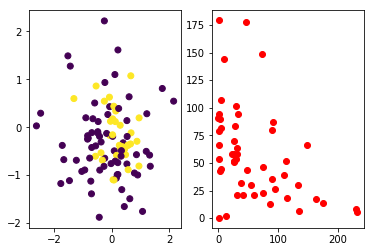

In [190]:
#Visualizing pca
data = x

print(x.shape)
#print(data[1:10, :])
bools = y
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(data[100:200, 0], data[100:200, 1], c = y[100:200])
#ax1.scatter(data[2500:, 0], data[2500:, 1], c = 'b')
ax2.scatter(x_tr[:50, 3], x_tr[:50, 1], c = 'r')
plt.show()

Ideas:
- standardize
- polynomials
- fourier transformation
- sine, cos, tan ...ect
- look up kvantemechanics formulas an see if we can find some correlations

### Train and produce weigths 

In [137]:
initial_w = np.zeros(len(x[1]))
max_iters = 15 # low
gamma = 0.5
tx = np.transpose(x) 
ty = np.transpose(y)

losses, w = bf.least_squares(ty, x)

print(w.shape)


(15,)


### Optimalizing: determining overfit or underfit
http://cs229.stanford.edu/materials/ML-advice.pdf

### Visualize, find pattern of wrong predictions -> back to Exploratory/Feature Proc
http://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf

### Cross validation before kaggle

In [195]:
#w_ridge, rmse_ridge=      bf.ridge_regression(y_tr, x_tr, lambda_)

#loss_reglogreg, w_reglogreg, losses_reglogreg=    bf.reg_logistic_regression(y_tr, tx_tr, lambda_, initial_w, max_iters, gamma)


#*args = hyperparameters 

def cross_validation(function_to_run, y, x, num_of_k_fold, *args):
    
    losses = []
    pred_acc_percents = []
    
    k_indices = cv.build_k_indices(y, num_of_k_fold, 1)
    
    for k in range(num_of_k_fold):
        
        x_test, y_test, x_tr, y_tr = cv.split_k(x,y,k_indices, k)
        
        if(function_to_run.__name__ == "reg_logistic_regression"):
            
            lambda_ = args[0]
            initial_w = args[1]
            max_iters = args[2]
            gamma = args[3]
            
            loss, weights, losses =  function_to_run(y_tr, x_tr, lambda_, initial_w, max_iters, gamma) 
            
        elif(function_to_run.__name__ == "ridge_regression"):
            
            lambda_ = args[0]
            
            weights, loss = bf.ridge_regression(y, x, lambda_)
        
        elif(function_to_run.__name__ == "least_squares"):
            
            ty = np.transpose(y)
            
            loss, weights = bf.least_squares(ty, x)
            
            
        losses.append(loss)

        pred_y = bf.log_pred(x, weights)    
        pred_acc_percent, soppel = bf.log_pred_acc(y, pred_y)
        pred_acc_percents.append(pred_acc_percent)
     
    
    loss_sum = 0
    for loss in losses:
        loss_sum += loss
    avg_loss = loss_sum / len(losses)
    
    acc_sum = 0
    for acc in pred_acc_percents:
        acc_sum += acc
    avg_acc = acc_sum / len(pred_acc_percents)
    
    return avg_loss, losses, avg_acc, pred_acc_percents 


lambda_=0.5
initial_w = np.zeros((x.shape[1], 1))
max_iters = 5
gamma = 0.01
k_folds = 5


avg_loss, losses, avg_preds, pred_acc_percents = cross_validation(bf.least_squares, y, x, k_folds)

#avg_loss, losses, avg_preds, pred_acc_percents = cross_validation(bf.reg_logistic_regression, y, x, k_folds, lambda_, initial_w, max_iters, gamma)

print("avg loss: ", avg_loss)
print("Losses: ", losses)
print("Average prediction NON-accuracy: ", avg_preds)
print("prediction NON-accuracy percents: ", pred_acc_percents)


avg loss:  0.417373193467
Losses:  [0.41737319346741897, 0.41737319346741897, 0.41737319346741897, 0.41737319346741897, 0.41737319346741897]
Average prediction NON-accuracy:  0.2986
prediction NON-accuracy percents:  [0.2986, 0.2986, 0.2986, 0.2986, 0.2986]


### Predict higgs boson

In [113]:
# Import test.csv which contains nonlabeled data
# Remember to have sub_sample=False when submitting to kaggle WARNING: it takes a looooong time
pred_y, pred_x, pred_ids = load_csv_data(test_path, sub_sample=False)
print(pred_x, pred_y)
print(pred_ids)

[[-999.      79.589   23.916 ..., -999.    -999.       0.   ]
 [ 106.398   67.49    87.949 ..., -999.    -999.      47.575]
 [ 117.794   56.226   96.358 ..., -999.    -999.       0.   ]
 ..., 
 [ 108.497    9.837   65.149 ..., -999.    -999.       0.   ]
 [  96.711   20.006   66.942 ..., -999.    -999.      30.863]
 [  92.373   80.109   77.619 ..., -999.    -999.       0.   ]] [ 1.  1.  1. ...,  1.  1.  1.]
[350000 350001 350002 ..., 918235 918236 918237]


In [114]:
pred_x = pca(pred_x, 30)[0]

In [115]:
weights = w


y_pred = predict_labels(weights, pred_x)
print(y_pred[1:25])
print(y_pred.mean())


[-1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1. -1.
 -1. -1.  1.  1. -1.  1.]
-0.129449280055


In [117]:
# creates a file with the name you want in the folder of the Python-file. just look in the folder :) 
name = 'pca_testing.csv'
create_csv_submission(pred_ids, y_pred, name)

#
# THE END
#